In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import json
import numpy as np
import torch

#sns.set_style("white", {"font": "serif"})
sns.set(font_scale=1.4)
sns.set_style('white', {'font.family':'Helvectica'})

ABAU_41_DATA = {
    'Chinese transformer': {'unigram': 0.5229887962341309,
  'bigram': 0.7513302564620972,
  'outedge': 0.5828443765640259,
  'ignore': 0.6300477385520935,
  'add_interp': 0.5532901883125305,
  'mul_interp': 0.5365908741950989,
  'copycat': 0.508683979511261},
 'English transformer': {'unigram': 0.6500980854034424,
  'bigram': 0.5090360641479492,
  'outedge': 0.715187132358551,
  'ignore': 0.7869880795478821,
  'add_interp': 0.4787653684616089,
  'mul_interp': 0.4868844151496887,
  'copycat': 0.4102855324745178},
 'Finnish transformer': {'unigram': 0.6155282258987427,
  'bigram': 0.6622210741043091,
  'outedge': 0.6666368246078491,
  'ignore': 0.7326148152351379,
  'add_interp': 0.5568457245826721,
  'mul_interp': 0.5427842736244202,
  'copycat': 0.5118857622146606},
    "English GRU": {"unigram": 0.7767780423164368, "bigram": 0.6356952786445618, "outedge": 0.7854129672050476, "ignore": 0.8393816351890564, "add_interp": 0.6266373991966248, "mul_interp": 0.583559513092041, "copycat": 0.5187951922416687},
    "Finnish GRU": {"unigram": 0.5438895225524902, "bigram": 0.6961760520935059, "outedge": 0.4991966187953949, "ignore": 0.5026070475578308, "add_interp": 0.48344558477401733, "mul_interp": 0.4225654900074005, "copycat": 0.2934763431549072},
    "Chinese GRU": {"unigram": 0.48498988151550293, "bigram": 0.7463394999504089, "outedge": 0.4362708032131195, "ignore": 0.4593313932418823, "add_interp": 0.41904568672180176, "mul_interp": 0.384884238243103, "copycat": 0.299516886472702},
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
results = torch.load('restart-results.pt')

In [20]:
t_results = torch.load('restart-transformer-results.pt')

In [26]:
with open("bpe-noise-grid-data.json") as reader:
    bpe_noise_data = json.load(reader)
    
with open("/raid/lingo/jda/code/my-rnn/gru.json") as reader:
    gru_data = json.load(reader)

with open("/raid/lingo/jda/code/my-rnn/transformer.json") as reader:
    transformer_data = json.load(reader)
    
noises = ["symbol_swap", "symbol_mask", "symbol_dropout", "state_reset", "state_skip", "state_noise", "state_dropout"]

def fix_hyp_names(result, language, model = 'GRU', both_interp=True):
    pretty_names = {
        "copycat": "Random\nRestart",
        "ngram(2)": "Local\nContext",
        "ngram(1)": "Unigram",
        "skip": "Ignore",
        "mean_dist_state": "Global\nContext",
        "interp_add": "Interp.\n(add.)",
        "interp_mul": "Interp.\n(mul.)"
    }
    new_result = dict(**result)
    new_result["hypothesis"] = pretty_names[result["hypothesis"]]
    new_result["language"] = language
    new_result['model'] = model
    return new_result

def fix_abau_hyp_name(name, both_interp=False):
    return {
        "unigram": "Unigram",
        "bigram": "Local\nContext",
        "outedge": "Global\nContext",
        "ignore": "Ignore",
        "add_interp": "Interp.\n(add.)",
        "mul_interp": "Interp.\n(mul.)",
        "copycat": "Random\nRestart"
    }[name]

AttributeError: 'list' object has no attribute 'get'

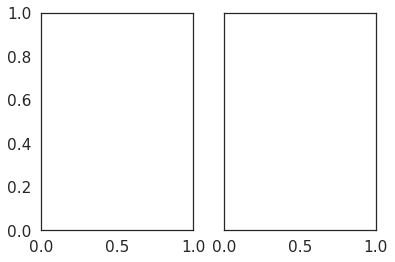

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
noise_free = []
for model, data, axis in [("GRU", gru_data, ax1), ('Transformer', transformer_data, ax2)]:
    for result_group in data:
        noise_type, = (n for n in noises if n in result_group[0])
        for result in result_group:
            if result["hypothesis"] in ("gt", "skip"):
                continue
            if result[noise_type] == 0:
                noise_free.append(fix_hyp_names(result, "Regular Langs.", model=model, both_interp=False))
                
    cap_langs = {'english': 'English', 'chinese': 'Chinese', 'finnish': 'Finnish'}
    
    if model == 'GRU':
        for lang, experiments in results.items():
            for restart in experiments:
                for hypothesis, result in restart.items():
                    #print(fix_abau_hyp_name(hypothesis))
                    noise_free.append({
                        'model': model,
                        "language": cap_langs[lang],
                        "extrap_acc": result.detach().cpu().numpy().tolist(),
                        "hypothesis": fix_abau_hyp_name(hypothesis),
                    })
    elif model == 'Transformer':
        for lang, experiments in t_results.items():
            for restart in experiments:
                for hypothesis, result in restart.items():
                    #print(fix_abau_hyp_name(hypothesis))
                    noise_free.append({
                        'model': model,
                        "language": cap_langs[lang],
                        "extrap_acc": result.detach().cpu().numpy().tolist(),
                        "hypothesis": fix_abau_hyp_name(hypothesis),
                    })

df = pd.DataFrame(noise_free)
df["real_extrap_acc"] = 1 - df["extrap_acc"]

g = sns.catplot(
    data=[df['model'] == 'GRU'],
    x="language",
    y="real_extrap_acc",
    hue="hypothesis",
    hue_order=["Unigram", "Global\nContext", "Local\nContext", "Interp.\n(mul.)", "Random\nRestart"],
    aspect=1.5,
    kind="bar",
    legend=True,
    palette={
        "Unigram": "#666666",
        "Global\nContext": "#0076ba",
        "Local\nContext": "#ee220c",
        "Interp.\n(add.)": "#d41876",
        "Interp.\n(mul.)": "#ff42a1",
        "Random\nRestart": "#feae00",
    },
)
plt.setp(g._legend.get_title(), fontsize=18)
g._legend.set_title("Hypothesis\n")
plt.ylim(0, 1)
plt.xlabel("Language")
g.axes[0][0].set_ylabel(f"Fit to GRU LM")
#g.axes[0][0].set_ylabel(f"Fit to GRU LM")
#g.axes[0][1].set_ylabel(f"Fit to Transformer LM")
plt.savefig(f"base.pdf")

In [8]:
g.axes[0][0].set_ylabel

NameError: name 'g' is not defined

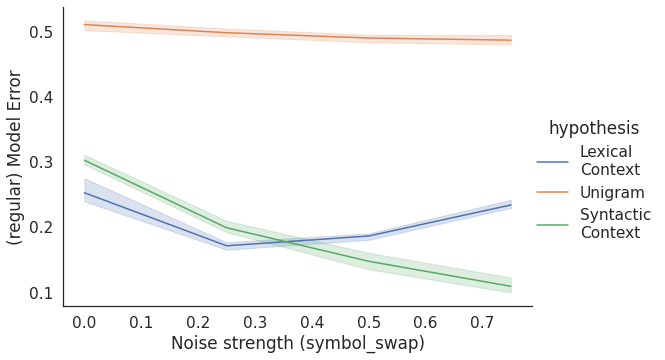

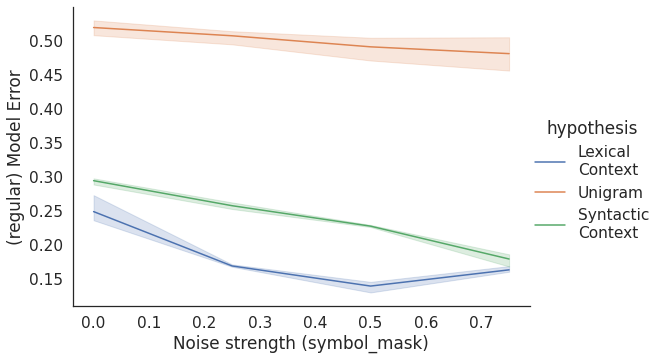

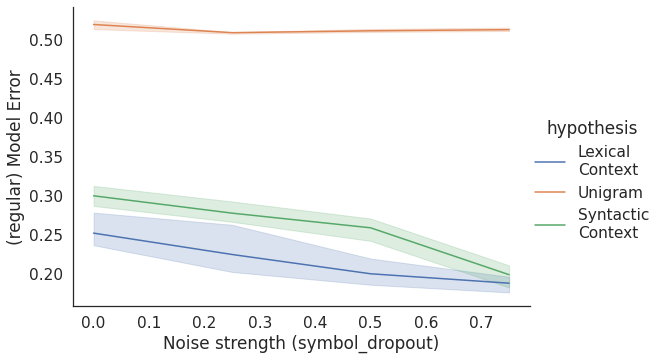

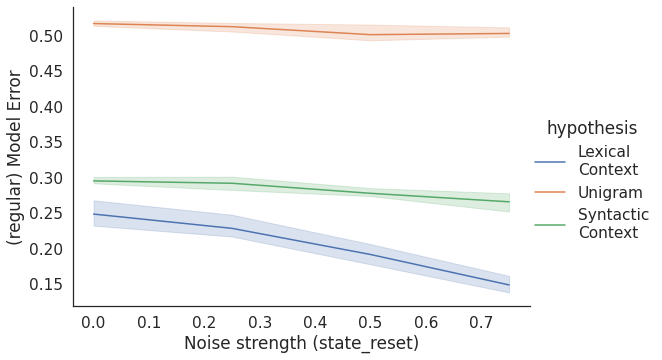

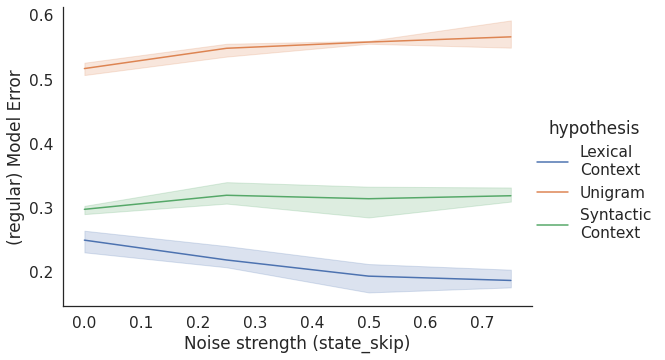

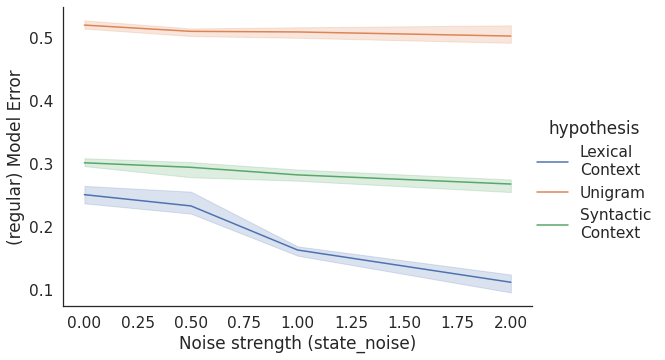

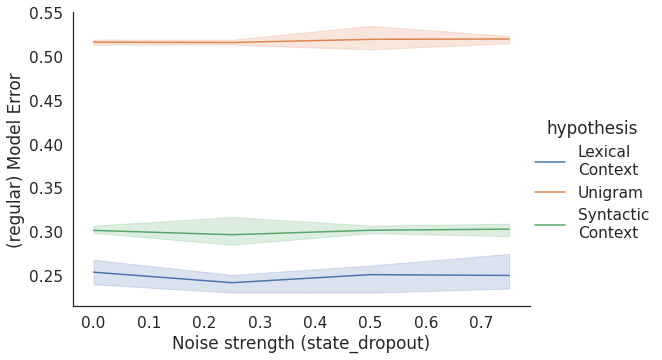

In [16]:
for model, data in [("regular", gru_data)]:
    for result_group in data:
        clean = []
        noise_type, = (n for n in noises if n in result_group[0])
        for result in result_group:
            if result["hypothesis"] == "gt":
                continue
            clean.append(fix_hyp_names(result, language="Regular Langs."))
        df = pd.DataFrame(clean)
        df = df[(df['hypothesis'] == 'Unigram') | (df['hypothesis'] == 'Syntactic\nContext') | (df['hypothesis'] == 'Lexical\nContext')]
        #display(df)
        #display(df)
        sns.relplot(
            data=df,
            x=noise_type,
            y="extrap_acc",
            hue="hypothesis",
            aspect=1.5,
            kind="line",
        )

        plt.xlabel(f"Noise strength ({noise_type})")
        plt.ylabel(f"({model}) Model Error")
        plt.savefig(f"{model}_{noise_type}.pdf")

In [10]:
noise_data = pd.DataFrame.from_dict(bpe_noise_data['finnish-subst'])

In [11]:
def make_for_dataset(dataset_str):
    noise_values = [0, 0.25, 0.5, 0.75]
    return pd.DataFrame([
        {
            'hypothesis': fix_abau_hyp_name(key),
            'noise': noise_values[i],
            'tvd': item
        }
        for key in bpe_noise_data[dataset_str]
        for i, item in enumerate(bpe_noise_data[dataset_str][key])
    ])

In [12]:
noise_data = make_for_dataset('finnish-subst')

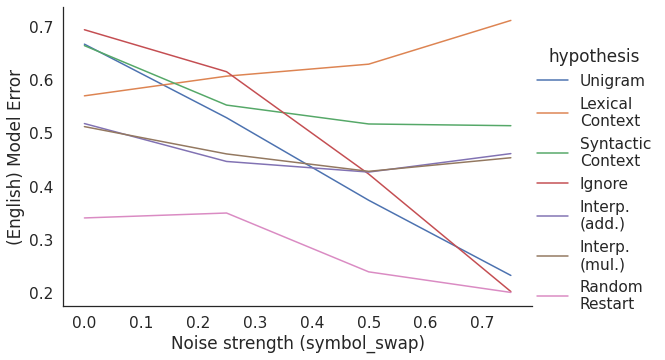

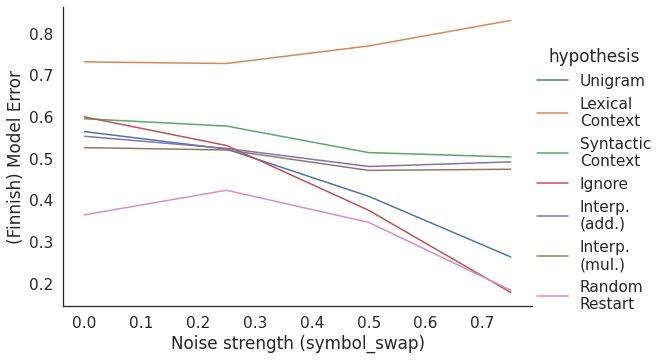

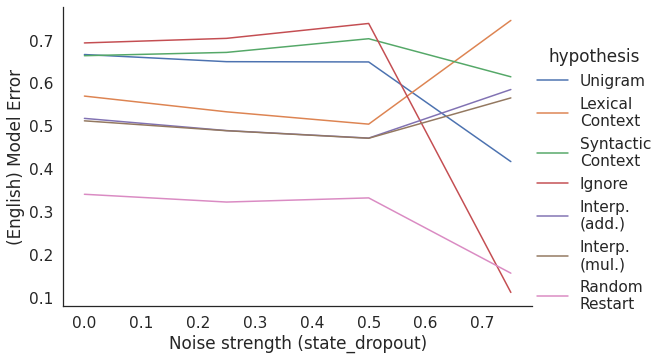

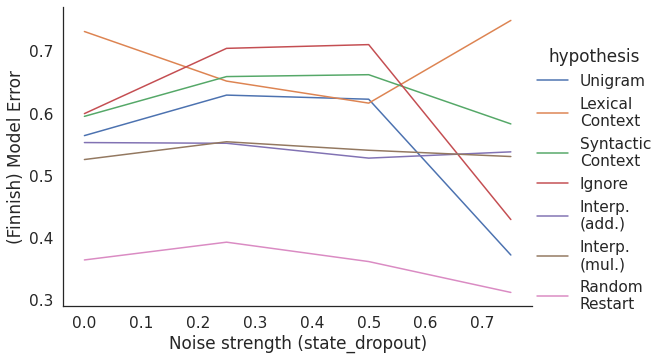

In [13]:
noise_name = {'subst': 'symbol_swap', 'state': 'state_dropout'}
language_name = {'english': 'English', 'finnish': 'Finnish'}
for noise_type in ['subst', 'state']:
    for language in ['english', 'finnish']:
        sns.relplot(
            data=make_for_dataset('%s-%s' % (language, noise_type)),
            x='noise',
            y='tvd',
            hue='hypothesis',
            aspect=1.5,
            kind="line"
        )
        plt.xlabel(f"Noise strength ({noise_name[noise_type]})")
        plt.ylabel(f"({language_name[language]}) Model Error")
        plt.savefig(f"{model}_{noise_type}.pdf")

In [14]:
noise_data

,hypothesis,noise,tvd
0,Unigram,0.00,0.563857
1,Unigram,0.25,0.521973
2,Unigram,0.50,0.408505
3,Unigram,0.75,0.262787
4,Lexical\nContext,0.00,0.731227
5,Lexical\nContext,0.25,0.727352
6,Lexical\nContext,0.50,0.769505
7,Lexical\nContext,0.75,0.830782
8,Syntactic\nContext,0.00,0.594808
9,Syntactic\nContext,0.25,0.577111
